# **Irrigation Scheduling Using Soil Moisture Sensors** <br />
Rain Garden Plant Species Water Management Assessment 


In [2]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import display, Math, Latex

## Prepared by B. Keith Bellingham, <br />
Soil Scientist, <br />
October 13, 2022<br/>
https://www.linkedin.com/in/bkbellingham/


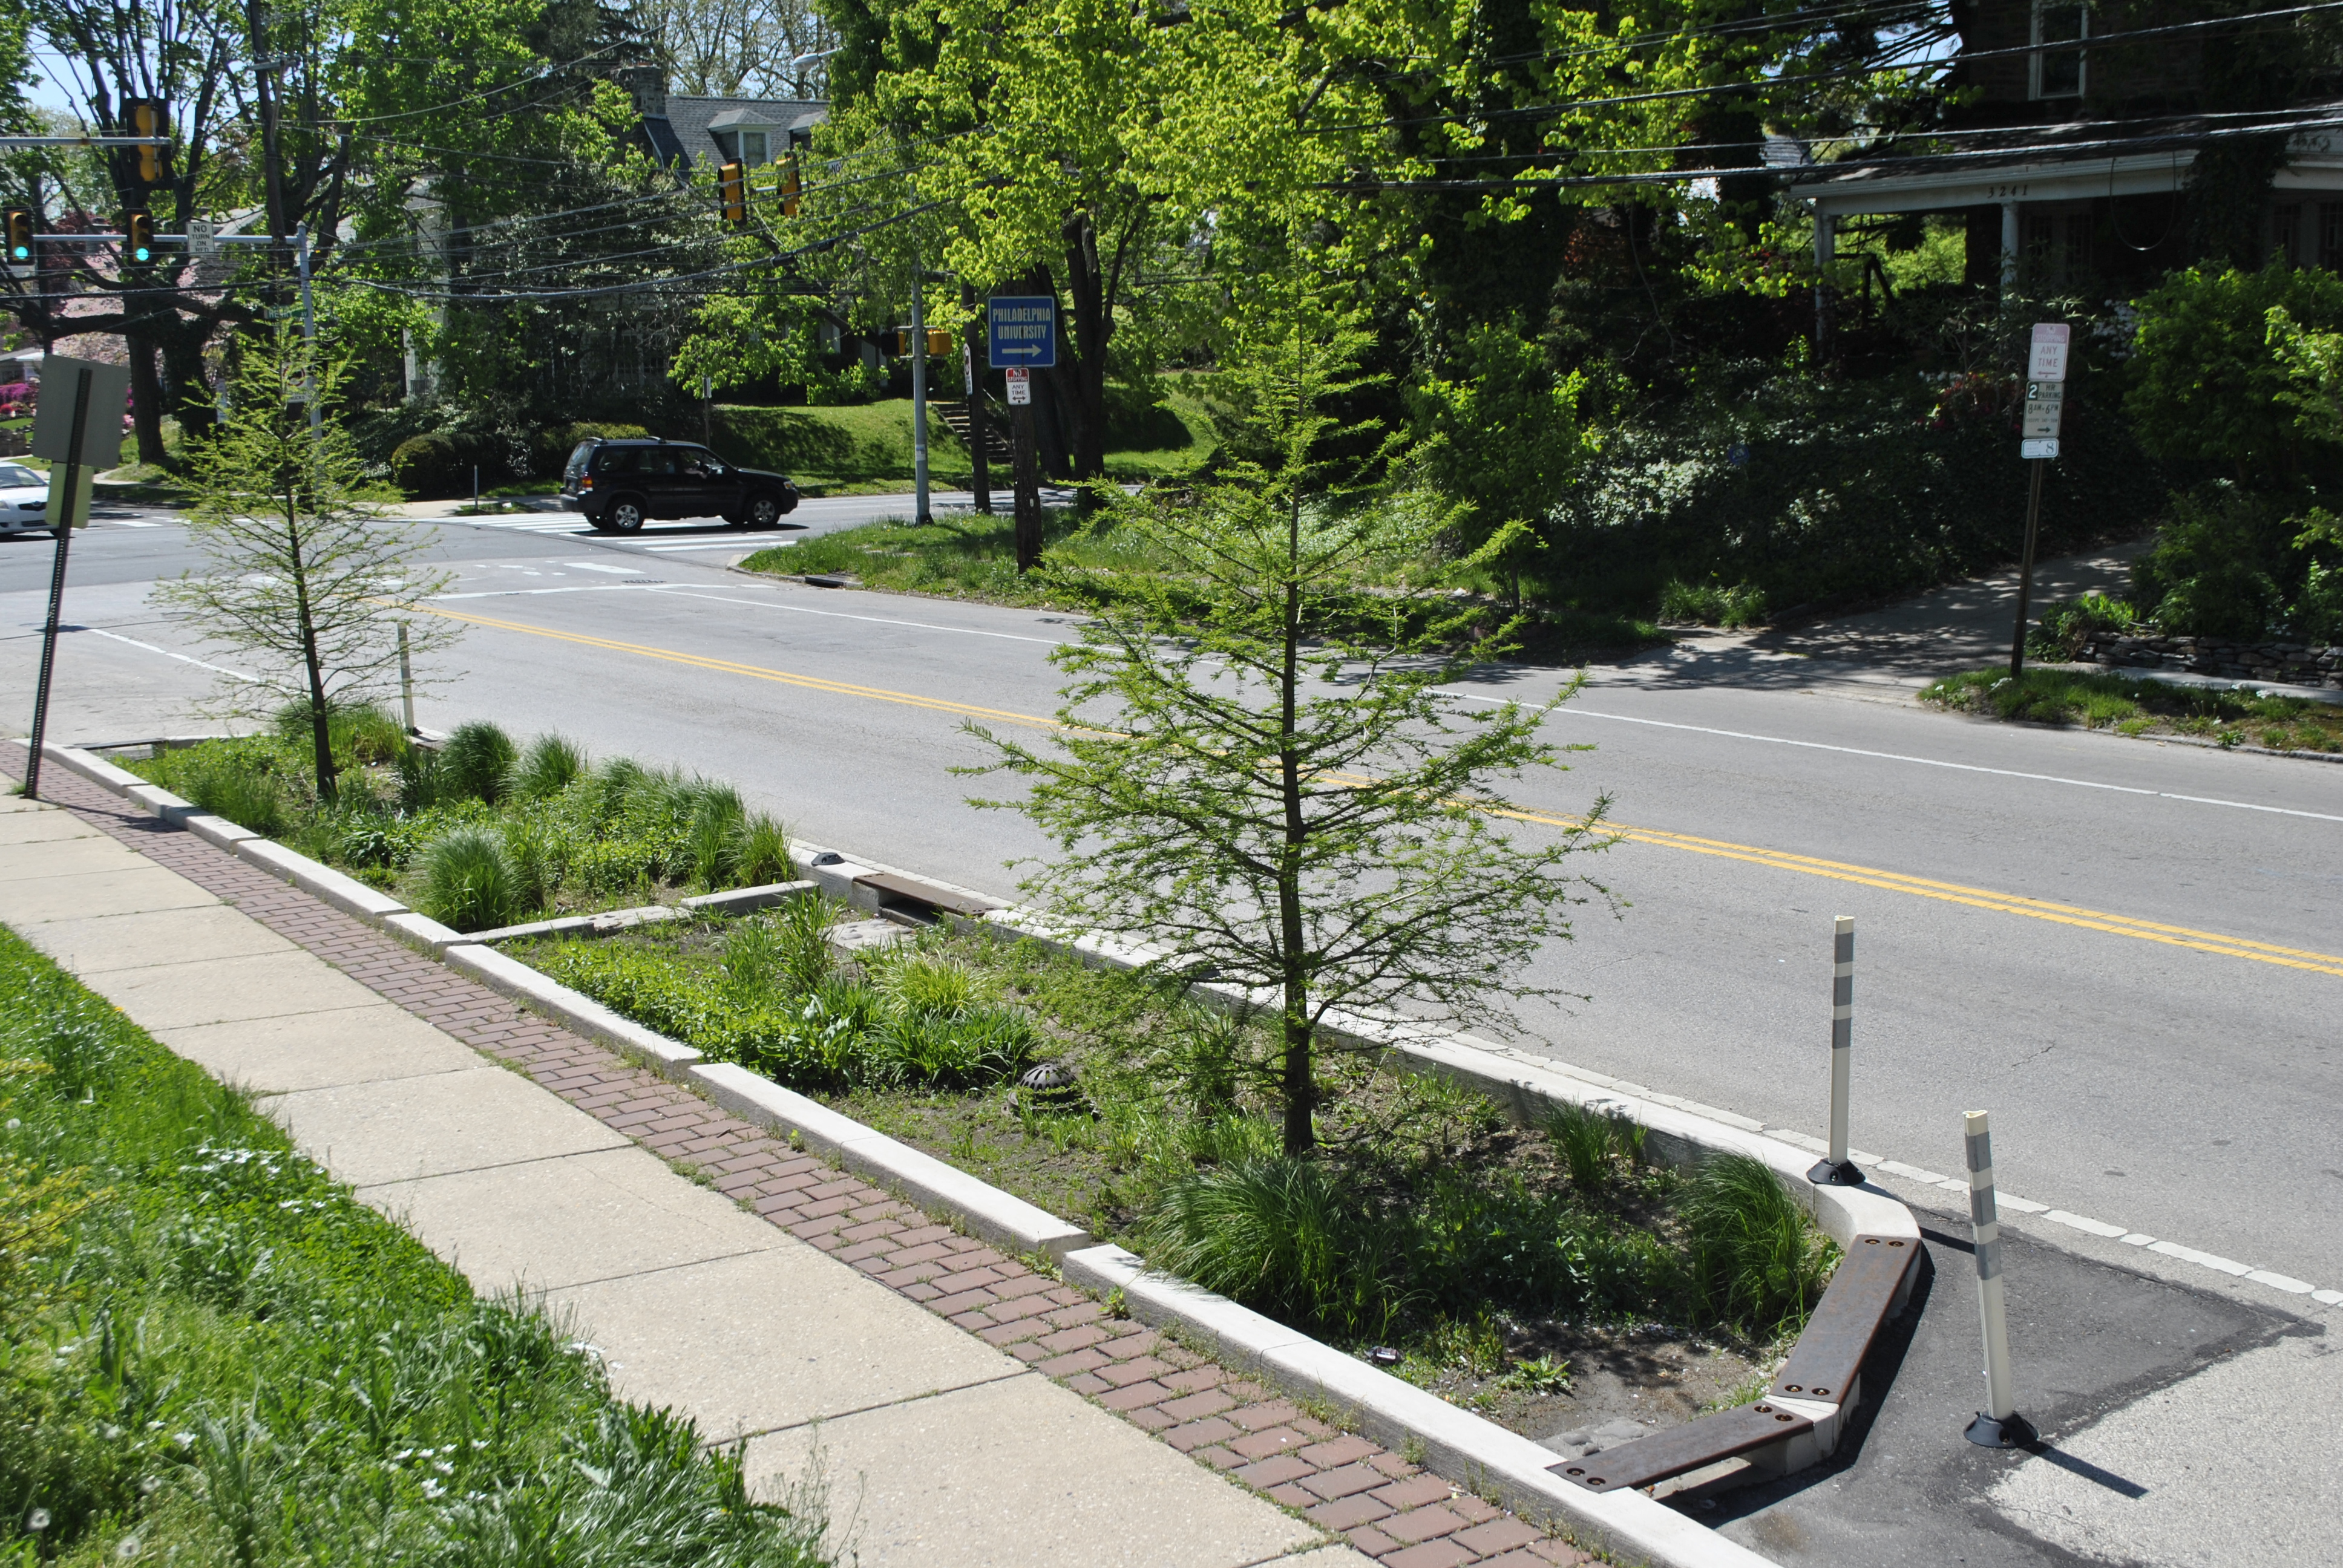

In [18]:
#Bring in Data
df_raw = pd.read_csv('https://raw.githubusercontent.com/KeithBellingham/Irrigation_Scheduling/main/RainGarden.csv')
df_raw.shape

(14889, 4)

In [20]:
df_f = df_raw.iloc[7000:10000]
df_f.head()

Time      wfv_1      wfv_2      wfv_3
7000  6/4/22 8:45  23.476951  20.388335  20.142405
7001  6/4/22 9:00  23.476951  20.302906  20.142405
7002  6/4/22 9:15  23.367694  20.106473  20.142405
7003  6/4/22 9:30  23.636009  20.106473  20.142405
7004  6/4/22 9:45  23.364815  20.018843  20.140844

**Introduction**<br />
Stormwater runoff from urban roads and streets is a potential source of surface water pollution. Rain Gardens have been a proven way to filter and adsorb stormwater for not only streets but parking lots and industrial site. The soils and plant species in the rain gardens must be engineered to survive dry summer periods while being able to transpire large amounts of water during the rainier seasons. The soils need to drain freely while holding enough water to keep the plants alive when it is not raining.   These test sites are rain gardens in Portland Oregon that compare several soil mixes with a variety for plant species. Each rain garden contains four soil moisture sensors at a depth of 8 inches and the total depth of the soil is about 50 inches. The data was logged every 15 minutes year-round. The rain gardens are managed by the City of Portland and are occasionally irrigated in the summer months from a water truck and a hand line.   

**Theory**<br />
The relationship between soil moisture and crop health is not straightforward and usually not well understood.  Techniques and tools commonly used in the field of data science are used to understand the flow and retention of water in the soil.  

Water movement in soil is driven by two physical forces, gravity and capillarity. If the soil is completely saturated or very wet (After an irrigation event), the primary force acting on the water will be gravity and can be best discribed be Darcy’s Law; 


$$\frac{\partial \theta}{\partial t} = flow  = -K_s(dh/dz)$$

Where $\theta$  is volumetric soil moisture, $K_s$ is the saturated hydraulic conductivity, *h* is hydraulic head and *z* is depth.  

After gravity gets finish pulling the water out of the soil, the predominant force acting on the water is capillary forces which is the force of the surface tension between water and air. Water movement from capillary forces is commonly called “wicking” and is described by the Richard’s Equation;


$$\frac{\partial \theta}{\partial t} = flow  =   \frac{\partial (K_h   \frac{\partial h}{\partial z}         }{\partial z} )  + \frac{\partial K_h} {\partial z }   -S(h) $$    



In the Richard’s equation $K_h$ is now the head dependent hydraulic conductivity, and $-S(h)$ is basically evaporation. 

In plant/water dynamics, the optimal soil water content for most crops and most plants is call the available water capacity (AWC) and is largely a function of the soil. The upper limit of the AWC is the soil’s “field capacity”. The field capacity is an important hydrological threshold in agriculture and agronomy. Field capacity is defined as the soil moisture after the water drains out. It is where the gravitational force acting on the water in soil is equal to the capillary forces acting on the water and thus $K_h$ from the Richard’s equation is equal to $K_s$ in Darcy’s Law.  The lower limit of the AWC can be assumed to be 80% of the Field capacity. Basically, the optimal soil moisture for most crops is between field capacity and 80% of field capacity. 

Field capacity may be expensive and difficult to measure in the lab. Also, field capacity is highly variable because soil is highly variable. Factors such as compaction, organic matter, texture, particle size distribution, and the roots of the plant all affect the soil moisture values where field capacity would occur.  Because of this variability, each individual soil sensor experiences a local field capacity, and the mathematical and algorithmic determination of field capacity needs to be carried out for each sensor separately.

 Since the local soil field capacity is not likely to change during a grow season, a select time range of the soil moisture time series data can be chosen as training data. This would eliminate errors in the calculation of field capacity if the crop is under or over irrigated.    

The goal is to determine the AWC and determine when crops would become stressed form the time series soil moisture data. 


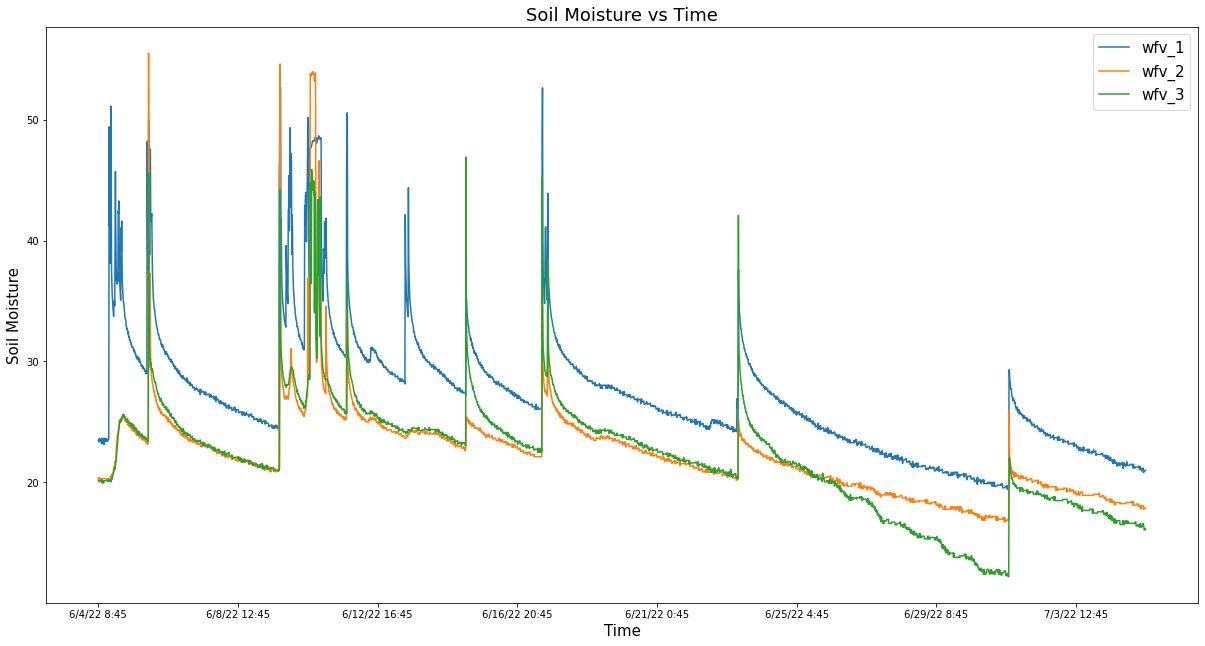

In [5]:
#Plot Data. 
#Each soil sensor is measuring percent moisture at 16 cm below surface. 
x = df_f['Time']
y_1 = df_f['wfv_1']
y_2 = df_f['wfv_2']
y_3 = df_f['wfv_3']

fig = plt.figure(figsize=(16,8))
axes_4 = fig.add_axes([0,0,1,1]) #this means you want the whole array
axes_4.set_xlabel('Time' ,fontsize=15,) 
axes_4.set_ylabel('Soil Moisture',fontsize=15)
axes_4.set_title('Soil Moisture vs Time',fontsize=18)
axes_4.plot(x, y_1, label='wfv_1')
axes_4.plot(x, y_2, label='wfv_2')
axes_4.plot(x, y_3, label='wfv_3')
axes_4.legend(loc='best',fontsize=15)


plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))

plt.show()

**Methods**<br />

Water enters the urban rain garden during the dry season mainly from a periodic unscheduled visits from a water truck.  In this case, the Richard’s Equation can be simplified to;

$$\frac{\partial \theta}{\partial t} = flow $$ 

The flow is calculated from a rolling slope of the soil moisture time series data.  Large positive slopes are observed during irrigation and indicate water entering the system. The dewatering of the soil after the irrigation event are a negative slopes and field capacity is assumed to occur when the rolling slope is from -0.1 to -0.05.  The moisture when the rolling slope is from -0.1 to -0.05 is averaged over a range of times when the soils are irrigated. To make sure the correct soil moisture is chosen during a dewatering event, the rolling difference of the min/max is used as a filter. This filter helps remove slopes that fall within the target range of -0.1 to -0.05 but are not associated with a post-irrigation dewatering. This could occur if it rains after an irrigation event or a warm windy morning creates high evapotranspiration which removes water that had wicked upward overnight.    



# Senor 1, determination of field capacity based on slope of drainage

In [15]:
#Each senor will experiance its own field capacity
j1 = df_f[['Time', 'wfv_1']]
j1.head()

Time      wfv_1
7000  6/4/22 8:45  23.476951
7001  6/4/22 9:00  23.476951
7002  6/4/22 9:15  23.367694
7003  6/4/22 9:30  23.636009
7004  6/4/22 9:45  23.364815

The Field Capasity is  30.15135296302326 And the Lower Limit is  24.12108237041861


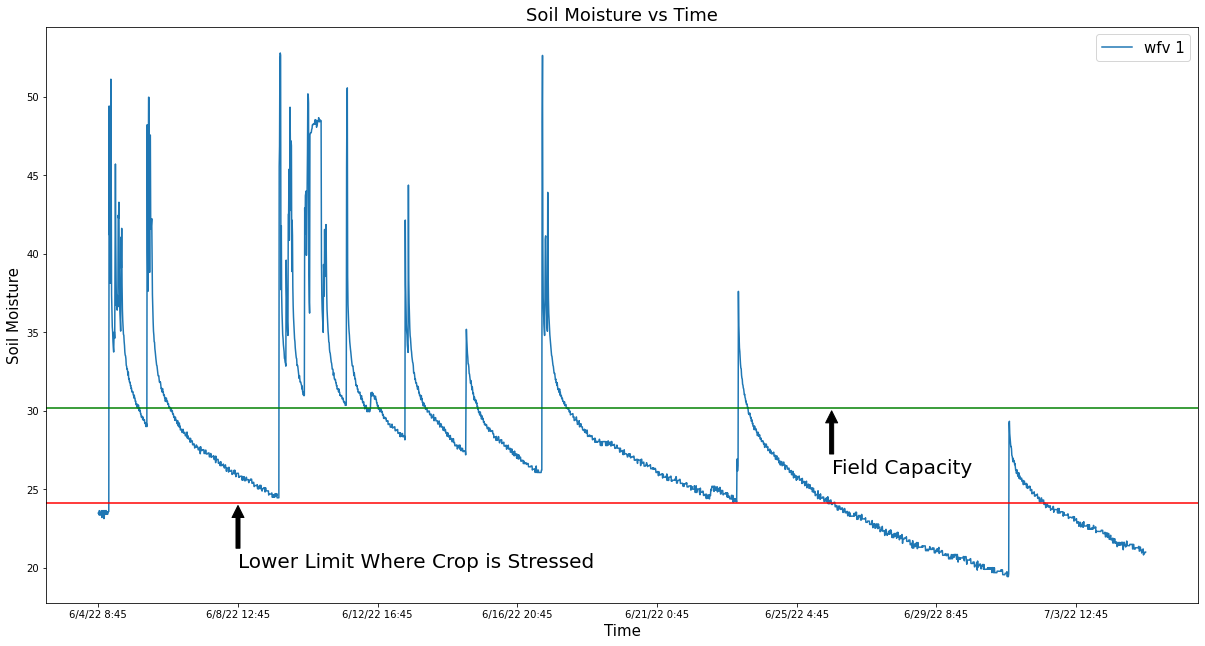

In [17]:
#Set rolling window sizes and use a dial to determine field capacity.
std_frame = 3
minmaxframe = 10
time_frame = 7

#get rolling slope
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope


j1['rolling_slope'] = j1['wfv_1'].rolling(window=time_frame, center=True,
                               min_periods=time_frame).apply(get_slope)

#get rolling min max differance 
j1['minmaxdif'] = (j1['rolling_slope'].rolling(window=minmaxframe,center=False).max())-(j1['rolling_slope'].rolling(window=minmaxframe,center=False).min())
j1['rstd'] = j1['wfv_1'].rolling(window=std_frame).std()


#see where the slope changes sign, not used in this model

j1['sign'] = (j1['rolling_slope'].abs())/j1['rolling_slope']
j1['signa'] = j1['sign'].rolling(window=2).sum()



#Pick out FC.
#Field Capacity is assumed to be when the rolling slope is between -0.1 and -0.05.
#The difference between the rolling min and max is used to 
#filter the targeted slope ranges to only times of dewatering after an irrigation event.  


fc_df = j1.loc[(j1['rolling_slope']<-0.05 )& 
                (j1['minmaxdif']<.05) & (j1['rolling_slope']>-0.1)]
fc = fc_df['wfv_1'].mean()
LL1 = fc*0.8

print("The Field Capasity is ", fc, "And the Lower Limit is ", LL1)


#Graphing
x = j1['Time']
y = j1['wfv_1']

x_a = j1.loc[j1.index[2100], 'Time']
x_b = j1.loc[j1.index[400], 'Time']

fig = plt.figure(figsize=(16,8))
axes_4 = fig.add_axes([0,0,1,1]) 
axes_4.set_xlabel('Time' ,fontsize=15,) 
axes_4.set_ylabel('Soil Moisture',fontsize=15)
axes_4.set_title('Soil Moisture vs Time',fontsize=18)
axes_4.plot(x, y, label='wfv 1')


axes_4.legend(loc='best',fontsize=15)

plt.axhline(y = fc, color = 'g', label = 'Field Capasity')
plt.axhline(y = LL1, color = 'r', label = 'Lower Limit')

axes_4.annotate('Field Capacity', xy=(x_a ,fc),fontsize=20, xytext=(x_a, 26),
                arrowprops=dict(facecolor='black', shrink=0.05))

axes_4.annotate('Lower Limit Where Crop is Stressed', xy=(x_b ,LL1),fontsize=20, xytext=(x_b, 20),
                arrowprops=dict(facecolor='black', shrink=0.05))

plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))

plt.show()


In [8]:
j1[1295:1300]

Time      wfv_1  rolling_slope  minmaxdif      rstd  sign  \
8295  6/17/22 20:30  34.376836      -0.282396   1.835193  0.229948  -1.0   
8296  6/17/22 20:45  34.119386      -0.245989   1.569500  0.226984  -1.0   
8297  6/17/22 21:00  33.702032      -0.226700   1.177228  0.340545  -1.0   
8298  6/17/22 21:15  33.512886      -0.208787   1.085002  0.310323  -1.0   
8299  6/17/22 21:30  33.470117      -0.185102   1.108688  0.123417  -1.0   

      signa  
8295   -2.0  
8296   -2.0  
8297   -2.0  
8298   -2.0  
8299   -2.0

In [9]:
fctest = j1.loc[(j1['rolling_slope']<-0.05) & 
                (j1['minmaxdif']<.05) & (j1['rolling_slope']>-0.1)]
fctest.describe()

wfv_1  rolling_slope  minmaxdif       rstd  sign  signa
count  86.000000      86.000000  86.000000  86.000000  86.0   86.0
mean   30.151353      -0.067733   0.040271   0.105969  -1.0   -2.0
std     1.332464       0.013314   0.006980   0.050343   0.0    0.0
min    23.678893      -0.097886   0.017338   0.000000  -1.0   -2.0
25%    29.432547      -0.077940   0.035824   0.107334  -1.0   -2.0
50%    30.506923      -0.063445   0.041900   0.115392  -1.0   -2.0
75%    30.983188      -0.057677   0.045665   0.129240  -1.0   -2.0
max    31.782960      -0.050798   0.049980   0.222875  -1.0   -2.0

In [11]:
print("The Field Capacity is ", fc, "And the Lower Limit is ", LL1)
d = 50

#Determine water deficit below lower limit of a soil column 50 cm deep. 
j1['def'] = j1['wfv_1'] - LL1
j1['d'] =  (j1['def']/100)*d 

Add_cm_water = j1.loc[(j1['d']<0) & (j1['Time'])]
Add_cm_water.head()

The Field Capacity is  30.15135296302326 And the Lower Limit is  24.12108237041861


Time      wfv_1  rolling_slope  minmaxdif      rstd  sign  signa  \
7000  6/4/22 8:45  23.476951            NaN        NaN       NaN   NaN    NaN   
7001  6/4/22 9:00  23.476951            NaN        NaN       NaN   NaN    NaN   
7002  6/4/22 9:15  23.367694            NaN        NaN  0.063080   NaN    NaN   
7003  6/4/22 9:30  23.636009      -0.012220        NaN  0.134926  -1.0    NaN   
7004  6/4/22 9:45  23.364815      -0.017952        NaN  0.155749  -1.0   -2.0   

           def         d  
7000 -0.644131 -0.322066  
7001 -0.644131 -0.322066  
7002 -0.753389 -0.376694  
7003 -0.485074 -0.242537  
7004 -0.756268 -0.378134

# Sensor 2 using the same method and same rolling windows

In [12]:
j2 = df_f[['Time', 'wfv_2']]
j2.head()

Time      wfv_2
7000  6/4/22 8:45  20.388335
7001  6/4/22 9:00  20.302906
7002  6/4/22 9:15  20.106473
7003  6/4/22 9:30  20.106473
7004  6/4/22 9:45  20.018843

The Field Capacity is  25.392557455714286 And the Lower Limit is  20.31404596457143


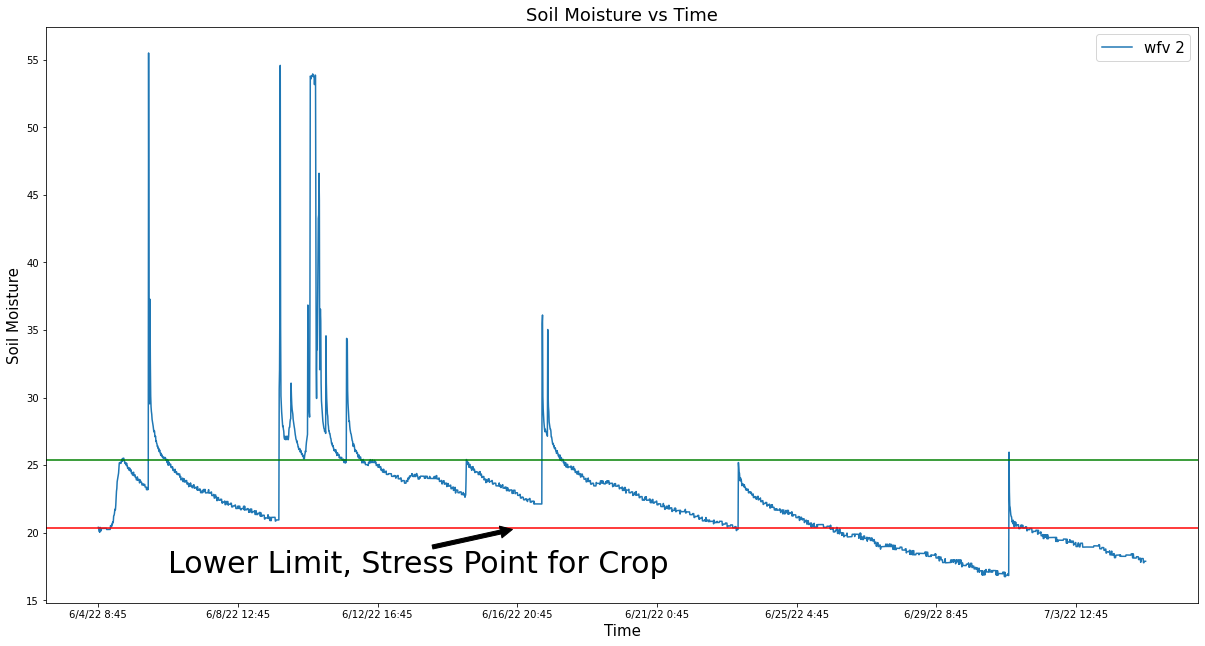

In [14]:
std_frame = 3
minmaxframe = 10
time_frame = 7

#get rolling slope
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

j2['rolling_slope'] = j2['wfv_2'].rolling(window=time_frame, center=True,
                               min_periods=time_frame).apply(get_slope)


#get rolling min max differance 
j2['minmaxdif'] = (j2['rolling_slope'].rolling(window=minmaxframe,center=False).max())-(j2['rolling_slope'].rolling(window=minmaxframe,center=False).min())

j2['rstd'] = j2['wfv_2'].rolling(window=std_frame).std()


#see where the slope changes sign

j2['sign'] = (j2['rolling_slope'].abs())/j2['rolling_slope']
j2['signa'] = j2['sign'].rolling(window=2).sum()



#Pick out FC


fc_df = j2.loc[(j2['rolling_slope']<-0.05 )& 
                (j2['minmaxdif']<.05) & (j2['rolling_slope']>-0.1)]
fc = fc_df['wfv_2'].mean()
LL1 = fc*0.8

print("The Field Capacity is ", fc, "And the Lower Limit is ", LL1)


#Graphing
x = j2['Time']
y = j2['wfv_2']
x_a = j2.loc[j2.index[1200], 'Time']
x_b = j2.loc[j2.index[200], 'Time']


fig = plt.figure(figsize=(16,8))
axes_4 = fig.add_axes([0,0,1,1]) #this means you want the whole array
axes_4.set_xlabel('Time' ,fontsize=15,) #rotation='vertical')
axes_4.set_ylabel('Soil Moisture',fontsize=15)
axes_4.set_title('Soil Moisture vs Time',fontsize=18)
axes_4.plot(x, y, label='wfv 2')

axes_4.legend(loc='best',fontsize=15)

axes_4.annotate('Lower Limit, Stress Point for Crop', xy=(x_a ,LL1),fontsize=30, xytext=(x_b, 17),
                arrowprops=dict(facecolor='black', shrink=0.05))

plt.axhline(y = fc, color = 'g', label = 'Field Capacity')
plt.axhline(y = LL1, color = 'r', label = 'Lower Limit')

plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))

plt.show()


**Conclusion**<br />

The same methods for determination of field capacity were applied to each soil sensor. The data suggests stress levels in the plants species in the summer months when irrigation is less frequent.  


**References**<br />

Šimůnek, J., M. Th. Van Genuchten, M. Sejna. 2008. "Development and Applications of the HYDRUS and STANMOD Software Packages and Related Codes." Vadose Zone J 587-600.

Assouline, S., and D. Or. 2014. "The concept of field capacity revisited: Defining intrinsic static and dynamic criteria for soil internal drainage dynamics." Water Resour. Res., 50, 4787– 4802, doi:10.1002/2014WR015475. . 

Bean, E. Z., R. G. Huffaker, and K. W. Migliaccio. 2018. "Estimating Field Capacity from Volumetric Soil Water Content Time Series Using Automated Processing Algorithms." Vadose Zone J. 17:180073. doi:10.2136/vzj2018.04.0073. 

Chandler, D. J., M. S. Seyfried, J. P. McNamara. and K. Hwang1. 2017. "Inference of Soil Hydrologic Parameters from Electronic Soil Moisture Records." Front. Earth Sci., Sec. Hydrosphere https://doi.org/10.3389/feart.2017.00025.
FAO-56. (1988). Crop and Evapotranspiration-Guidelines for Computing Crop Water Retirements Irrigation and Drainage. Food and Agriculture Organization of the United Nations.


Navin K. C. Twarakavi, Masaru Sakai, and Jirka Sˇimu ̊nek. 2009. "An objective analysis of the dynamic nature of field capacity." WATER RESOURCES RESEARCH, VOL. 45, W10410 doi:10.1029/2009WR007944.

Seyfried, M.S., L.E. Grant, E. Du, and K. Humes, and Seyfried. 2005. "Dielectric loss and calibration of the Hydra Probe soil water sensor." Vadose Zone J. 4: 1070-1079.

van Genuchten, M.T. 1980. "A closed-form equation for predicting the hydraulic conductivity of unsaturated soils." Soil Sci. Soc. Am. 44: 892-898.

Warrick, A. W. 2003. Soil Water Dynamics. Oxford University Press.

Zotarelli, L., M. D. Dukes, and K. T. Morgan. 2019. "Interpretation of Soil Moisture Content to Determine Soil Field Capacity and Avoid Over-Irrigating Sandy Soils Using Soil Moisture Sensors." University of Florida, Institute of Food and Agricultural Sciences (IFAS) AE460.

